# Bear Classification Notebook
Following uses `fastai` library which is built on top of `pytorch` to build ML models.
It uses transfer learning and fine-tunes the `resnet18` model to make a classifier model.

It also uses `nbdev` to automatically creat Python script from this notebook.

In [17]:
#|default_exp app

In [2]:
from fastbook import *
from ddgs import DDGS as dd

In [3]:
def my_search_images_online(search_term, min_results=150):
    iteration = 0
    image_urls = []
    while len(image_urls) < min_results:
        print(f"Downloding image data for search term: {search_term}")
        image_data = dd().images(query=search_term, num_results=200, page=iteration+1)
        print(f"Iteration: {iteration+1} | Length of fetched data: {len(image_data)}")
        iteration += 1
        if len(image_data) > 0:
            image_urls += [img_data.get('image') for img_data in image_data]
        if iteration >= 4:
            break
    return image_urls

In [ ]:
# Testing the image search function
img_urls = my_search_images_online('grizzly bear')
len(img_urls)

Downloding image data for search term: grizzly bear
Iteration: 1 | Length of fetched data: 98
Downloding image data for search term: grizzly bear
Iteration: 2 | Length of fetched data: 94


192

In [4]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

# if not path.exists():
#     path.mkdir()
#     for o in bear_types:
#         dest = (path/o)
#         dest.mkdir(exist_ok=True)
#         results = my_search_images_online(f'{o} bear')
#         download_images(dest, urls=results)

In [5]:
# Get image files in `path` recursively, only in `folders`
fns = get_image_files(path)
fns

(#468) [Path('bears/grizzly/ccd8a107-c120-401a-a414-8ba669db6621.jpg'),Path('bears/grizzly/ab60d3d6-f9e8-4676-b74e-72dccef7e5a2.jpg'),Path('bears/grizzly/e9209e94-c7ed-4101-8138-55ac8074a00f.jpg'),Path('bears/grizzly/16aeb824-a9b2-4f39-948d-38bacfe4ea17.jpg'),Path('bears/grizzly/4c0000f1-f64e-4de7-8b05-16b2f0a920ce.jpg'),Path('bears/grizzly/c8fb9552-a3ae-48bb-b88c-2af907a571b0.jpg'),Path('bears/grizzly/223731fc-5879-4b8d-aece-e3df832b4e64.jpg'),Path('bears/grizzly/ece3c25d-4062-478d-81b4-64710ebaa33d.jpg'),Path('bears/grizzly/15df9490-58ac-4b31-ad3c-96040f6dee88.jpg'),Path('bears/grizzly/e4508fc1-6267-4a7b-85bd-fec8df0431cb.jpg'),Path('bears/grizzly/643377c0-fa0d-480f-92f8-3862b249c7fb.jpg'),Path('bears/grizzly/5ceeb666-bad8-4d2a-92d3-1a7279112616.jpg'),Path('bears/grizzly/f8817fd6-6ce2-413c-98ed-7fb3988b1306.jpg'),Path('bears/grizzly/5f57adb3-cbbf-4aa3-8470-0303275b0f56.jpg'),Path('bears/grizzly/6437d0cd-c9e9-44d8-b5d6-388a70720708.jpg'),Path('bears/grizzly/b8101aaf-1756-4e37-9606-90c

In [7]:
# Checking corrupt files
failed = verify_images(fns)
failed

(#0) []

In [8]:
# `verify_images` returns an object that contains `map` method
failed.map(Path.unlink)

(#0) []

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

# Telling the source of data
dls = bears.dataloaders(path)

/Users/hanzy/.pyenv/versions/3.11.10/envs/fastenv/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


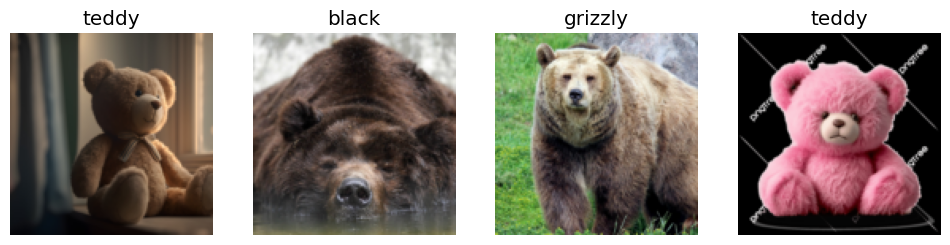

In [10]:
# Will show images loaded into the dataset
# But notice that some images look like cut outs
dls.valid.show_batch(max_n=4, nrows=1)

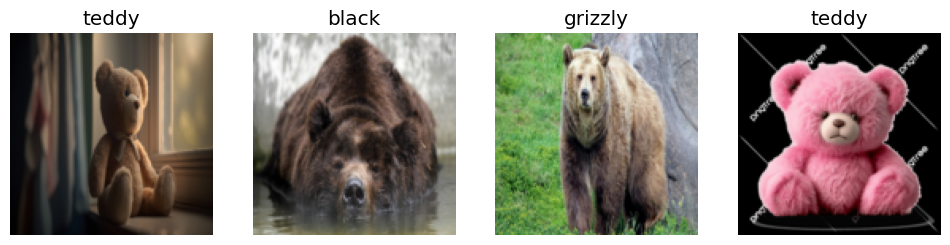

In [11]:
# Squising method puts the image in full
# But for images with not-right aspect ratio, the image doesn't look good
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

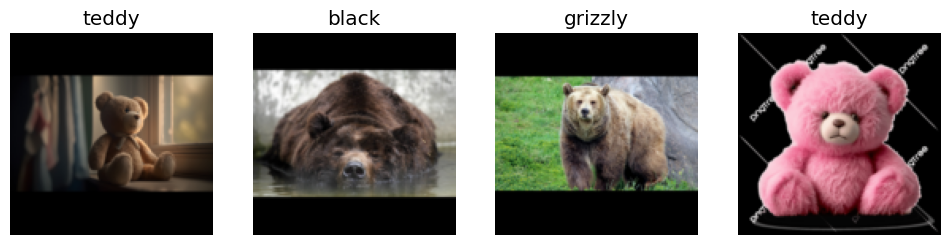

In [12]:
# This would put zero-padding to the image
# Making the image appear to the full
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

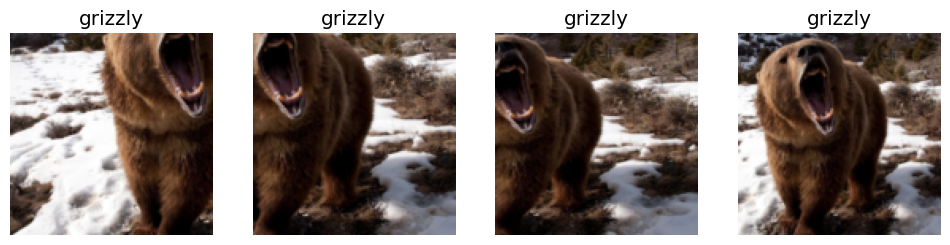

In [13]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

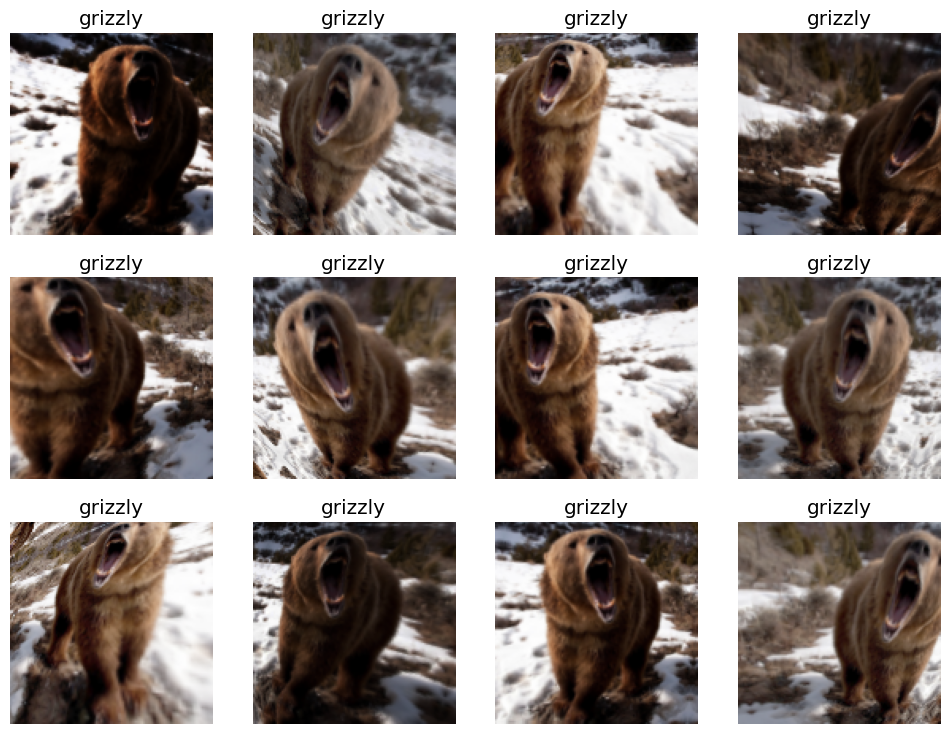

In [14]:
# Data Augmentation is like creating random variations of the same input image
# Image itself remains same
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=12, nrows=3, unique=True)

In [10]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/hanzy/.pyenv/versions/3.10.18/envs/fastenv2/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


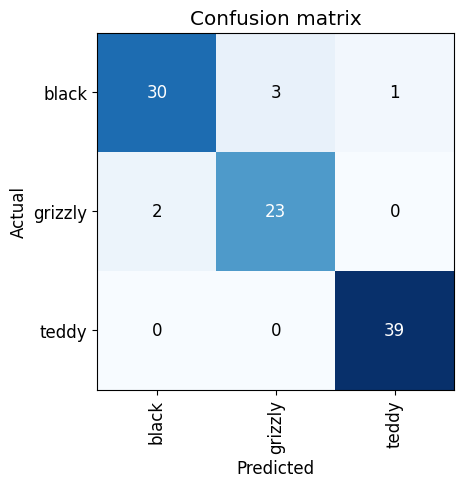

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

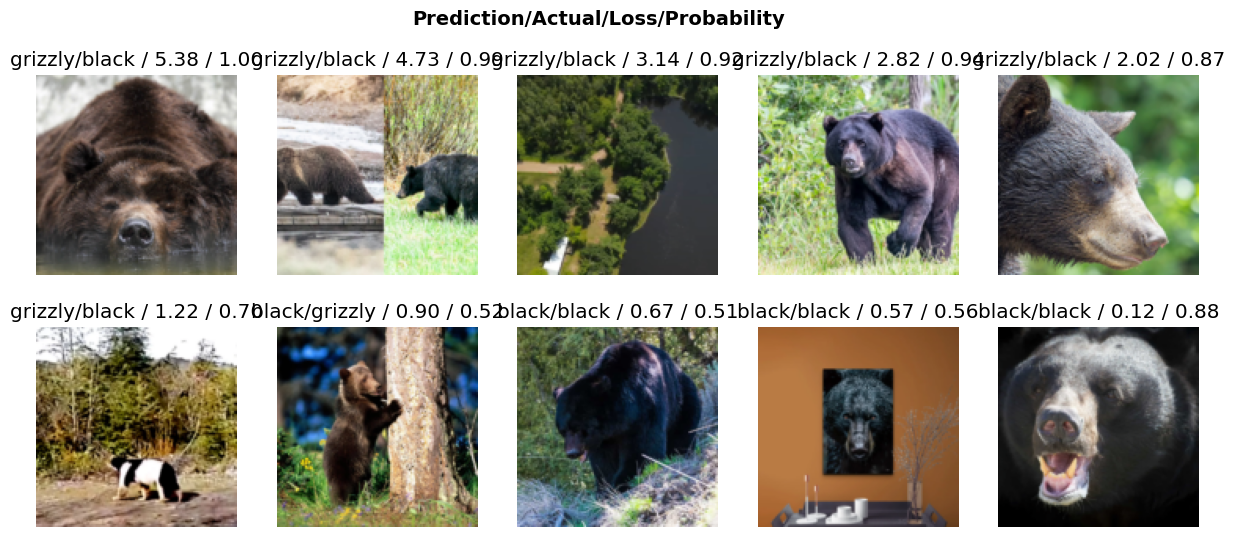

In [17]:
interp.plot_top_losses(10, nrows=2)

In [26]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/hanzy/.pyenv/versions/3.11.10/envs/fastenv/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

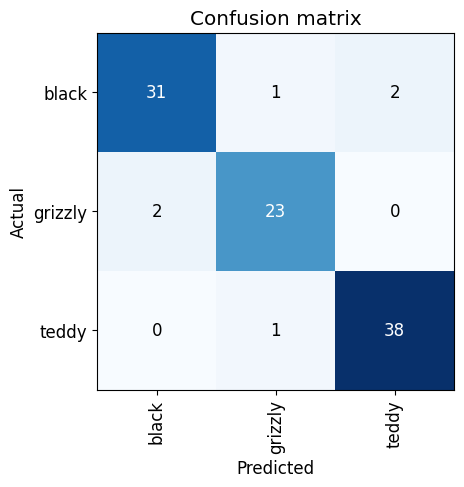

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

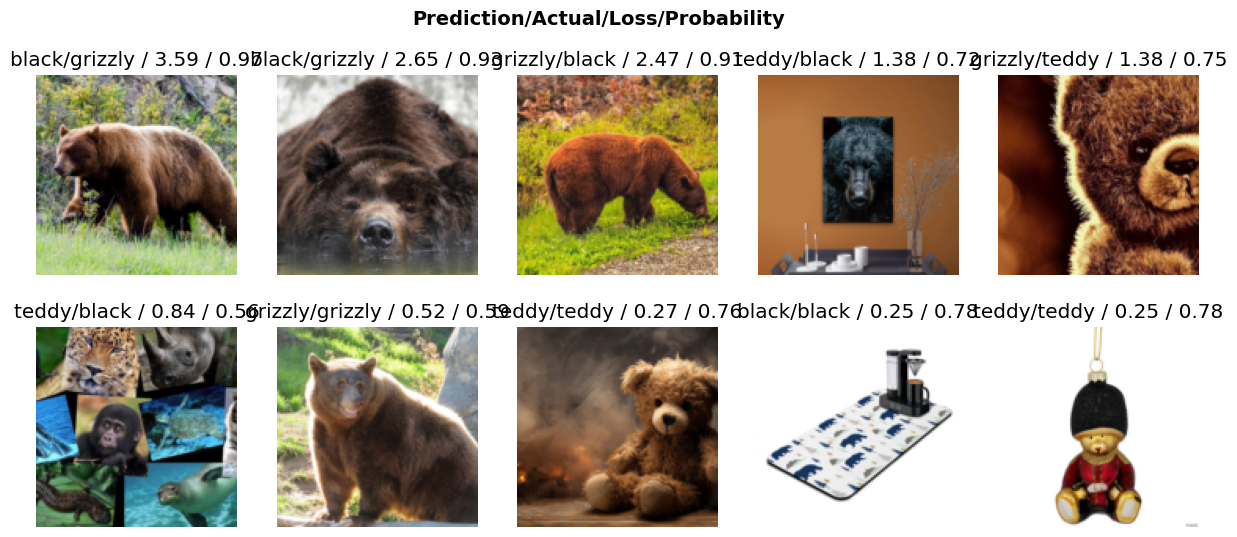

In [32]:
interp.plot_top_losses(10, nrows=2)

In [13]:
learn.export('ma_nigga.pkl')

In [58]:
learn.export('new_model.pkl', pickle_protocol=2)  # Older protocol version

In [35]:
# Loading Model
learn_inf = load_learner('export.pkl')

In [36]:
learn_inf.predict('images/grizzly1.jpg')

('grizzly', tensor(1), tensor([8.7787e-04, 9.9910e-01, 2.0073e-05]))

In [37]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [48]:
img = PILImage.create(btn_upload.data[-1])

out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [44]:
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:0.4}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9991')

In [45]:
btn_run = widgets.Button(description="Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

In [49]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:0.4}'

btn_run.on_click(on_click_classify)

btn_upload = widgets.FileUpload()

In [52]:
VBox(
    [
        widgets.Label('Select your bear!'),
        btn_upload,
        btn_run,
        out_pl,
        lbl_pred
    ]
)

In [54]:
# Gradio Work

categories = ('grizzly', 'black', 'teddy')

def classify_image(img):
    pred, pred_idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [55]:
classify_image(img)

{'grizzly': 0.0008778770570643246,
 'black': 0.999101996421814,
 'teddy': 2.007360126299318e-05}

In [19]:
from nbdev.export import nb_export as nb_e
# Cells that are marked with `#| export` will be added to a separate Python script
nb_e('bear-me.ipynb', '.')